# Clustering+dimension reduction

Натренувати як мінімум 2 моделі кластеризації.

Підібрати оптимальну кількість кластерів використовуючи як мінімум 2 метрики.

Побудувати графік втрати інформації при зменшенні розмірності.

Знайти оптимальну кількість кластерів і розбиття на кластери на перетворенному датасеті.

Порівняти розбиття екземплярів на кластери для повного датасету і після втраті 30% інформації.

https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29

In [51]:
# Підключаємо Google Drive з датасетами
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Імпортуємо всі необхідні бібліотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

%config InlineBackend.figure_format = "png"

# зчитуємо набір даних
datasets_path = "/content/drive/MyDrive/Colab Notebooks/south_german_credit/"
df = pd.read_csv(datasets_path + "SouthGermanCredit.asc", sep=" ")

In [53]:
pip install clustergram

In [54]:
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Перед початком аналізу датасету давайте перейменуємо колонки згідно опису в файлі codetable.txt, який описує датасет. Так буде трохи легше далі з ним працювати.

In [55]:
df = df.rename(
    columns={
        "laufkont": "status",
        "laufzeit": "duration",
        "moral": "credit_history",
        "verw": "purpose",
        "hoehe": "amount",
        "sparkont": "savings",
        "beszeit": "employment_duration",
        "rate": "installment_rate",
        "famges": "personal_status_sex",
        "buerge": "other_debtors",
        "wohnzeit": "present_residence",
        "verm": "property",
        "alter": "age",
        "weitkred": "other_installment_plans",
        "wohn": "housing",
        "bishkred": "number_credits",
        "beruf": "job",
        "pers": "people_liable",
        "telef": "telephone",
        "gastarb": "foreign_worker",
        "kredit": "credit_risk",
    }
)

In [56]:
df.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


# Аналіз датасету

In [57]:
# Подивимось на загальну інформацію по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1000 non-null   int64
 1   duration                 1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   amount                   1000 non-null   int64
 5   savings                  1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   other_debtors            1000 non-null   int64
 10  present_residence        1000 non-null   int64
 11  property                 1000 non-null   int64
 12  age                      1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  housing                  1000 non-null   int64
 15  numbe

In [58]:
# Перевіряємо чи є дублікати
df.duplicated().sum()

0

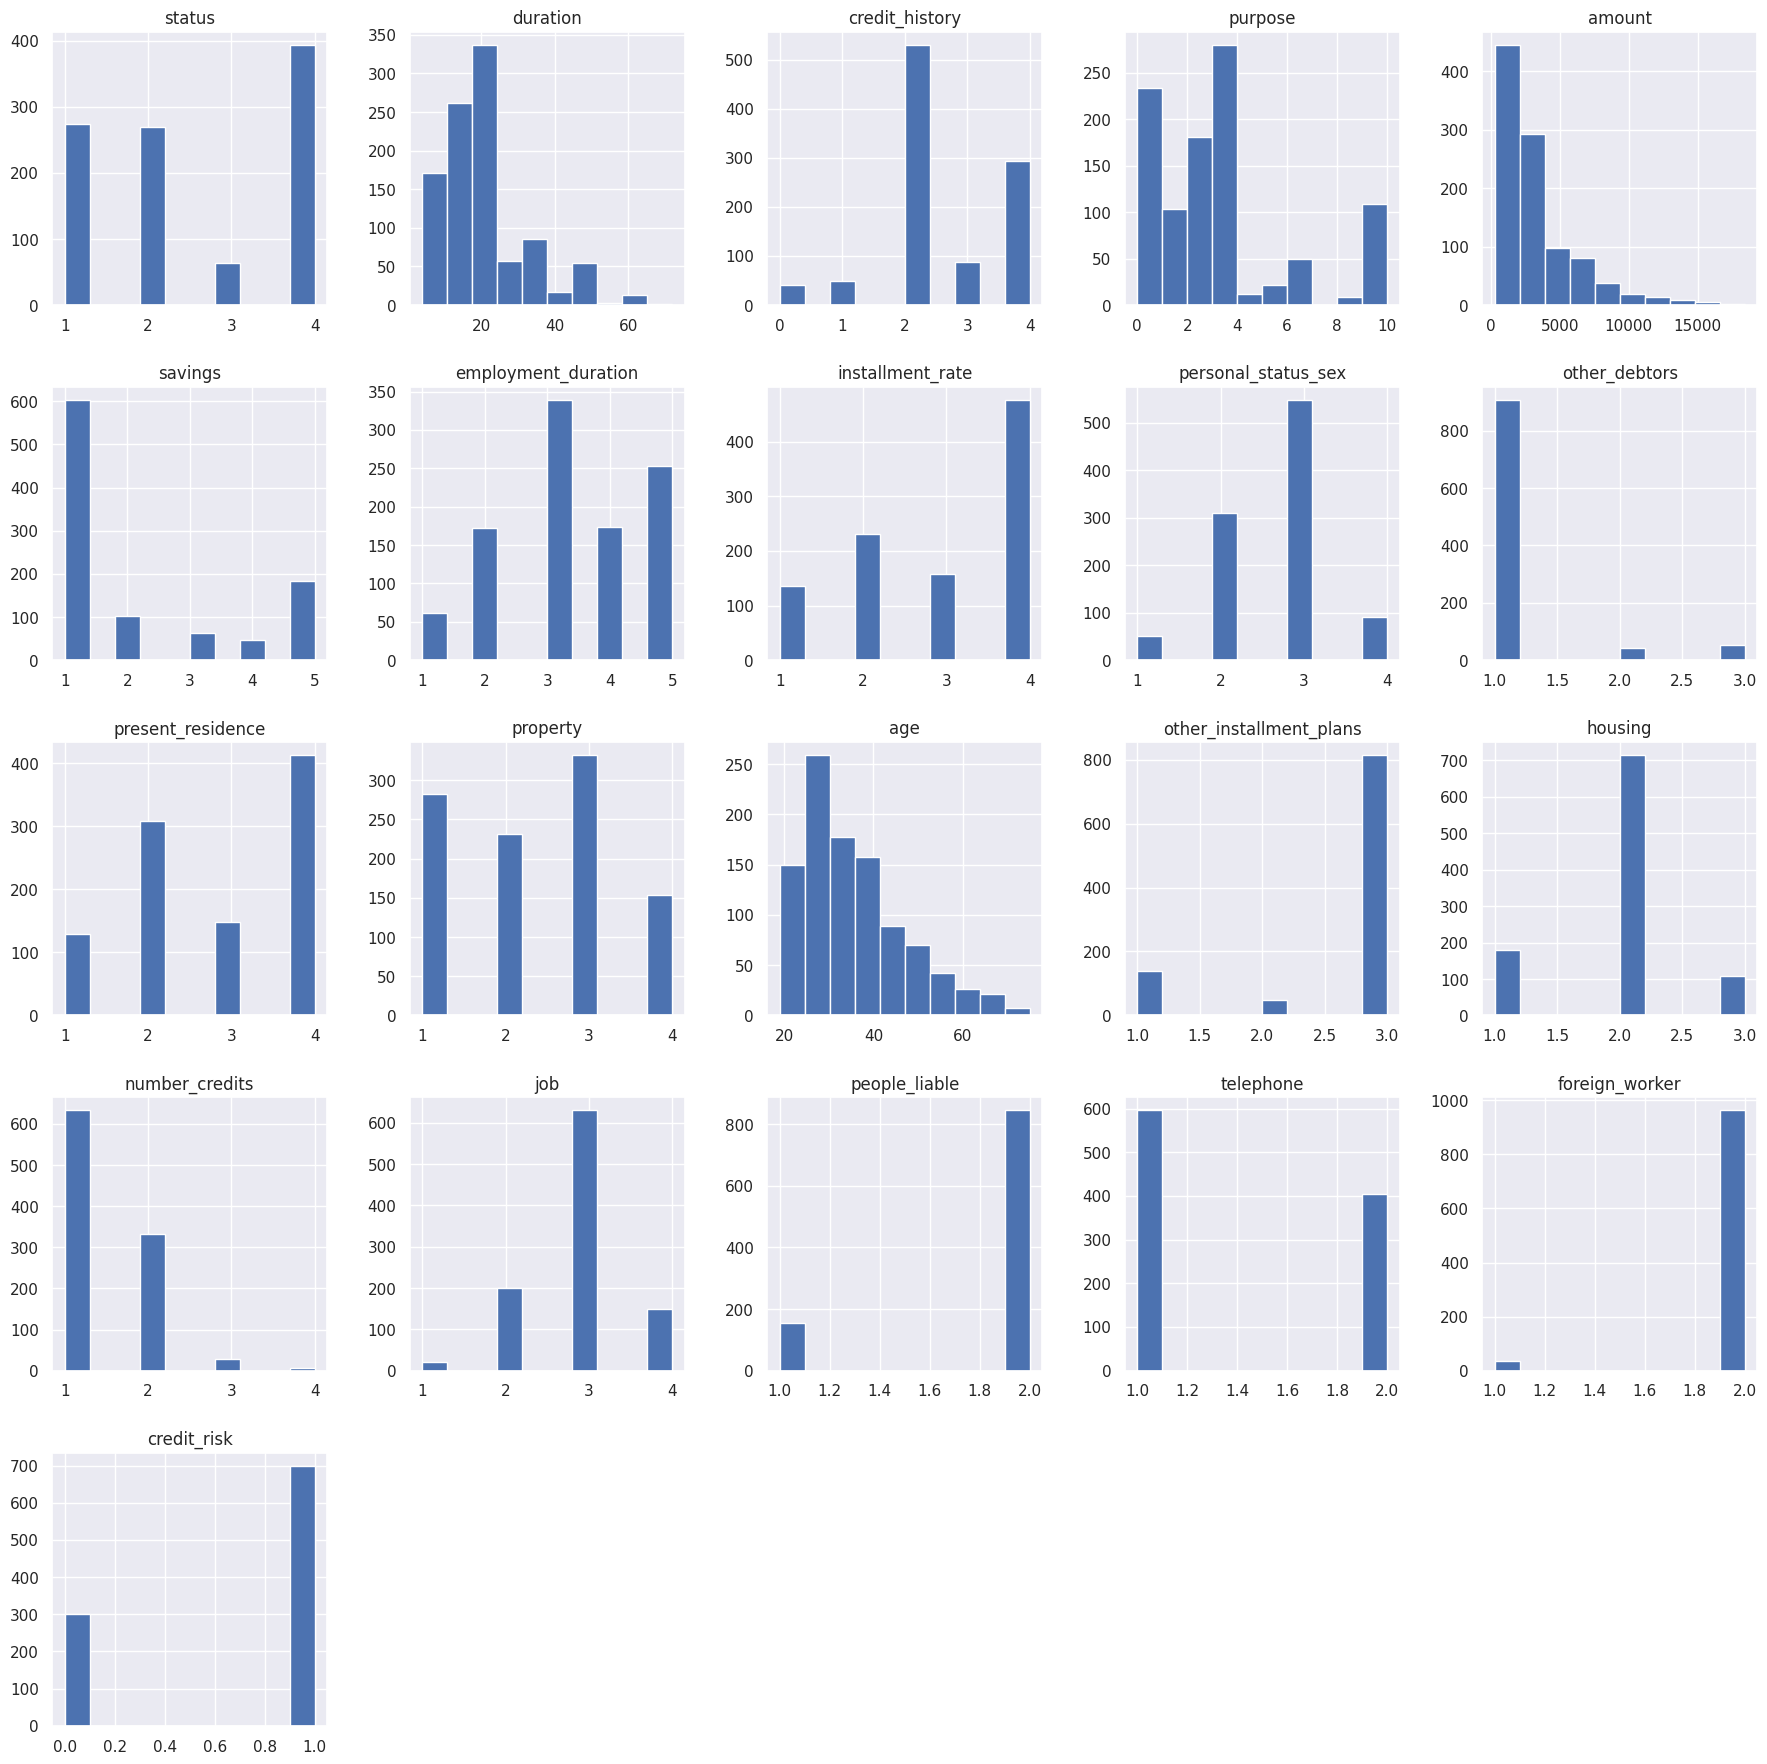

In [59]:
# Тепер подивимось на розподіл значень фічей
df.hist(figsize=(22, 22));

Бачимо що є фічі, від яких можно позбавитись, тому що у цих фічах дуже переважає одне із значень. Також можемо побачити що датасет не є збалансованим.

In [60]:
# Побудуємо pairplot щоб побачити кореляцію фічей
sns.pairplot(df, hue="credit_risk");

Output hidden; open in https://colab.research.google.com to view.

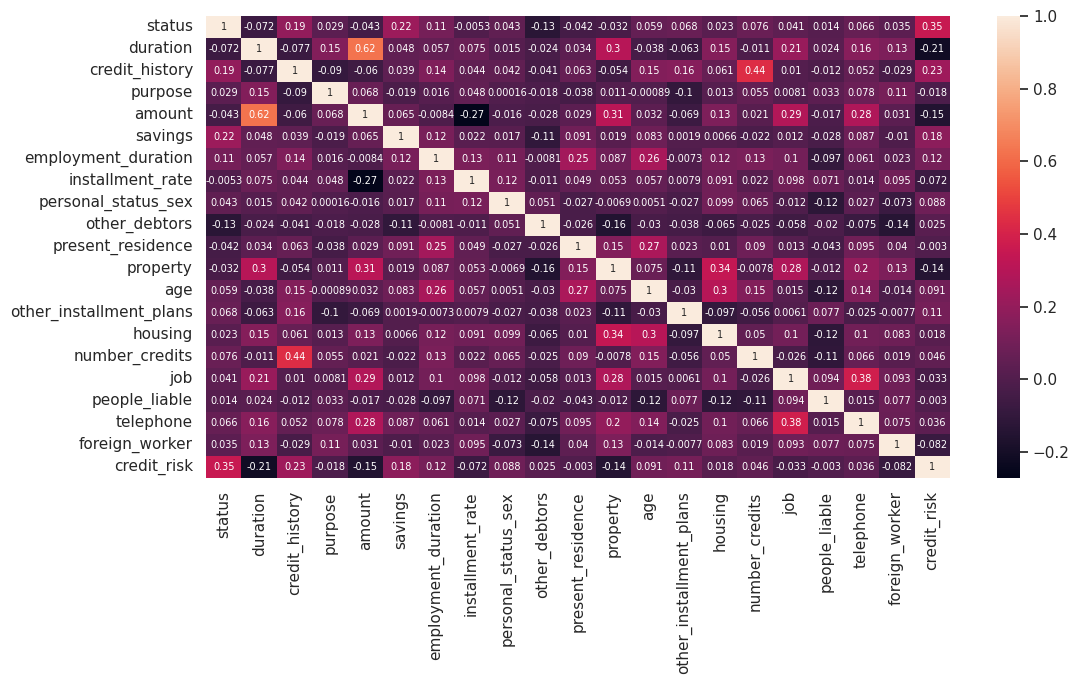

In [61]:
# Побудуємо матрицю кореляції та хітмапу, щоб краще побачити які фічі і наскільки кореляюють між собою
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

Можно сказати, що фічі цього датасету не корелюють між собою. Але, якщо подивитись на графіки вище, то можно побачити що є ряд фічів, де переважає одне значення, а інші виглядають як аутлеєри. Тож давайте проведемо поверхневий feature engineering.

# Масштабування фіч та feature engineering

In [62]:
df["foreign_worker"].value_counts()

2    963
1     37
Name: foreign_worker, dtype: int64

Фіча foreign_worker має лише 2 значення, при чому одне має вилику кількісну перевагу над iншим. Можемо позбавитись від цієї фічі.

In [63]:
df = df.drop(columns=["foreign_worker"])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1000 non-null   int64
 1   duration                 1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   amount                   1000 non-null   int64
 5   savings                  1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   other_debtors            1000 non-null   int64
 10  present_residence        1000 non-null   int64
 11  property                 1000 non-null   int64
 12  age                      1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  housing                  1000 non-null   int64
 15  numbe

In [65]:
df["other_debtors"].value_counts()

1    907
3     52
2     41
Name: other_debtors, dtype: int64

Виглядає так, що фічу other_debtors ми також можемо прибрати через дуже перекошений розподіл.

In [66]:
df = df.drop(columns=["other_debtors"])

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1000 non-null   int64
 1   duration                 1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   amount                   1000 non-null   int64
 5   savings                  1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   installment_rate         1000 non-null   int64
 8   personal_status_sex      1000 non-null   int64
 9   present_residence        1000 non-null   int64
 10  property                 1000 non-null   int64
 11  age                      1000 non-null   int64
 12  other_installment_plans  1000 non-null   int64
 13  housing                  1000 non-null   int64
 14  number_credits           1000 non-null   int64
 15  job  

In [68]:
# Зробимо масштабування фіч використовуючи MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(df)

# Кластеризація на початковому датасеті

In [69]:
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, Birch
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

max_clusters_num = 6

In [70]:
# KMeans
for k in range(2, max_clusters_num + 1):
  kmeans = KMeans(
      n_clusters=k,
      random_state=42,
      n_init="auto",
  ).fit(X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(X, kmeans.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, kmeans.labels_)}")
  print(f"Silhouette score: {silhouette_score(X, kmeans.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 2.375661761149921
Calinski and Harabasz score: 143.95634700596946
Silhouette score: 0.14543466588077622 

Number of clusters: 3
Davies-Bouldin score: 2.226079596855992
Calinski and Harabasz score: 140.57851065366884
Silhouette score: 0.13691137017927663 

Number of clusters: 4
Davies-Bouldin score: 2.2227207290974995
Calinski and Harabasz score: 110.79681265706401
Silhouette score: 0.12874628600494303 

Number of clusters: 5
Davies-Bouldin score: 2.2687341915158554
Calinski and Harabasz score: 94.8687032298984
Silhouette score: 0.10635401529751318 

Number of clusters: 6
Davies-Bouldin score: 2.4734717093579124
Calinski and Harabasz score: 86.85078151660494
Silhouette score: 0.09024117573245014 



Згідно моделі KMeans та метрикам оптимальною кількістю кластерів для даного датасету є 2 кластери. Додатково використаємо бібліотеку Clustergram для побудови графічного результату розділення на кластери алгоритмом KMeans.

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.17660212516784668 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=3 fitted in 0.3907744884490967 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=4 fitted in 0.536813497543335 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=5 fitted in 0.39871788024902344 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K=6 fitted in 0.5800728797912598 seconds.


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

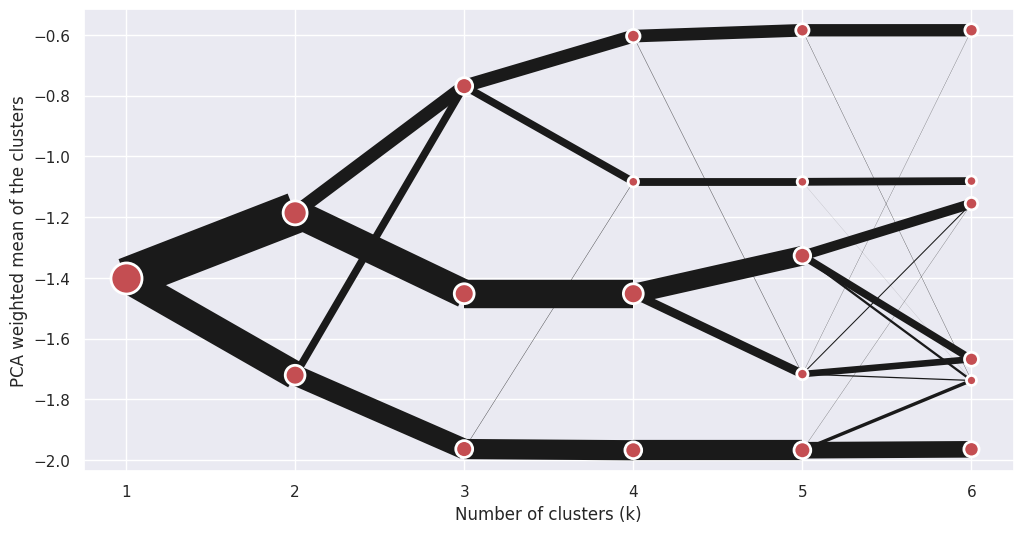

In [71]:
from clustergram import Clustergram

cgram = Clustergram(range(1, max_clusters_num + 1))
cgram.fit(X)
cgram.plot()

Бачимо що під час розбиття більше ніж на 2 кластери дані починають частково перетягуватись у інші кластери. Тож дійсно, 2 кластери є самим оптимальним варіантом.
Подивимось на метрики інших алгоритмів.

In [72]:
# AffinityPropagation
aff_prop = AffinityPropagation(random_state=42).fit(X)
print(f"Clusters labels: {np.unique(aff_prop.labels_)}")
print(f"Davies-Bouldin score: {davies_bouldin_score(X, aff_prop.labels_)}")
print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, aff_prop.labels_)}")
print(f"Silhouette score: {silhouette_score(X, aff_prop.labels_)}", "\n")

Clusters labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]
Davies-Bouldin score: 1.9178650974932945
Calinski and Harabasz score: 21.88131337583199
Silhouette score: 0.08985627565567933 



AffinityPropagation нарахував щось дуже багато кластерів. 75 кластери це забагато для такого датасету.

In [73]:
# MeanShift
ms = MeanShift(bandwidth=2).fit(X)
labels = np.unique(ms.labels_)

print(f"Clusters labels: {labels}")

if len(labels) > 1:
  print(f"Davies-Bouldin score: {davies_bouldin_score(X, ms.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, ms.labels_)}")
  print(f"Silhouette score: {silhouette_score(X, ms.labels_)}", "\n")

Clusters labels: [0]


MeanShift не дуже нам тут допоміг бо не розбив дані більш ніж на один кластер.

In [74]:
# SpectralClustering
for k in range(2, max_clusters_num + 1):
  kmeans = SpectralClustering(
      n_clusters=k,
      random_state=42,
  ).fit(X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(X, kmeans.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, kmeans.labels_)}")
  print(f"Silhouette score: {silhouette_score(X, kmeans.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 2.794114380529664
Calinski and Harabasz score: 122.05369951486765
Silhouette score: 0.10901328334022185 

Number of clusters: 3
Davies-Bouldin score: 2.244456109858382
Calinski and Harabasz score: 137.86210677562462
Silhouette score: 0.135214806685505 

Number of clusters: 4
Davies-Bouldin score: 2.3083733396001738
Calinski and Harabasz score: 107.5639146692757
Silhouette score: 0.10927568305471527 

Number of clusters: 5
Davies-Bouldin score: 2.1781029260546285
Calinski and Harabasz score: 92.41074090451943
Silhouette score: 0.10629407146676174 

Number of clusters: 6
Davies-Bouldin score: 2.2622319711379206
Calinski and Harabasz score: 85.23363528963246
Silhouette score: 0.13161347169047813 



SpectralClustering знайшов 3 кластери.

In [75]:
# AgglomerativeClustering
for k in range(2, max_clusters_num + 1):
  agg = AgglomerativeClustering(n_clusters=k).fit(X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(X, agg.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, agg.labels_)}")
  print(f"Silhouette score: {silhouette_score(X, agg.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 2.4537952864720425
Calinski and Harabasz score: 115.522068026091
Silhouette score: 0.12112996853074623 

Number of clusters: 3
Davies-Bouldin score: 2.502001485349814
Calinski and Harabasz score: 109.90908859851545
Silhouette score: 0.10918973181924849 

Number of clusters: 4
Davies-Bouldin score: 2.611376402227001
Calinski and Harabasz score: 100.15079121822677
Silhouette score: 0.10784444011616467 

Number of clusters: 5
Davies-Bouldin score: 2.2070695178173003
Calinski and Harabasz score: 92.42863325386361
Silhouette score: 0.12379743916914623 

Number of clusters: 6
Davies-Bouldin score: 2.2414247642901763
Calinski and Harabasz score: 86.1726990201188
Silhouette score: 0.12562393608797995 



AgglomerativeClustering по метрикам наче також натякає на 2 кластери.

In [76]:
# DBSCAN
for i in range(1, max_clusters_num):
  dbs = DBSCAN(eps=i, min_samples=2).fit(X)
  labels = np.unique(dbs.labels_)

  print(f"Epsilon value: {i}")
  print(f"Clusters labels: {labels}")

  if len(labels) > 1:
    print(f"Davies-Bouldin score: {davies_bouldin_score(X, dbs.labels_)}")
    print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, dbs.labels_)}")
    print(f"Silhouette score: {silhouette_score(X, dbs.labels_)}", "\n")

Epsilon value: 1
Clusters labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
Davies-Bouldin score: 1.69017122632249
Calinski and Harabasz score: 17.359651334105923
Silhouette score: 0.029355933538225725 

Epsilon value: 2
Clusters labels: [0]
Epsilon value: 3
Clusters labels: [0]
Epsilon value: 4
Clusters labels: [0]
Epsilon value: 5
Clusters labels: [0]


DBSCAN при значенні `eps=1` розбив щось на дуже багато кластерів. Також частину даних було позначено як шум.

In [77]:
# Birch
brc = Birch(n_clusters=None).fit(X)
print(f"Clusters labels: {np.unique(brc.labels_)}")
print(f"Davies-Bouldin score: {davies_bouldin_score(X, brc.labels_)}")
print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, brc.labels_)}")
print(f"Silhouette score: {silhouette_score(X, brc.labels_)}", "\n")

Clusters labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 2

Birch самостій знайшов 613 кластерів, це дуже багато для нас. Спробуємо ще раз цю модель, але з вказанням кількості кластерів.

In [78]:
for k in range(2, max_clusters_num + 1):
  brc = Birch(n_clusters=k).fit(X)
  print(f"Clusters labels: {np.unique(brc.labels_)}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(X, brc.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(X, brc.labels_)}")
  print(f"Silhouette score: {silhouette_score(X, brc.labels_)}", "\n")

Clusters labels: [0 1]
Davies-Bouldin score: 2.6591585753493114
Calinski and Harabasz score: 127.59076314622239
Silhouette score: 0.12198978090794822 

Clusters labels: [0 1 2]
Davies-Bouldin score: 2.2775562028623324
Calinski and Harabasz score: 98.36614617537566
Silhouette score: 0.105403450858177 

Clusters labels: [0 1 2 3]
Davies-Bouldin score: 2.610991240778447
Calinski and Harabasz score: 91.33561118165038
Silhouette score: 0.1092268309099494 

Clusters labels: [0 1 2 3 4]
Davies-Bouldin score: 2.3593614380060637
Calinski and Harabasz score: 87.72775115181707
Silhouette score: 0.11397143670643209 

Clusters labels: [0 1 2 3 4 5]
Davies-Bouldin score: 2.170531813409163
Calinski and Harabasz score: 84.9634644672714
Silhouette score: 0.11996032232061074 



За метриками Birch вважає що 2 - це наша кількість кластерів. Давайте тепер візуалізуємо дані за допомогою t-SNE.

# T-SNE на початковому датасеті

In [79]:
# t-SNE
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2, random_state=42).fit_transform(X)

[Text(0.5, 1.0, 'T-SNE projection')]

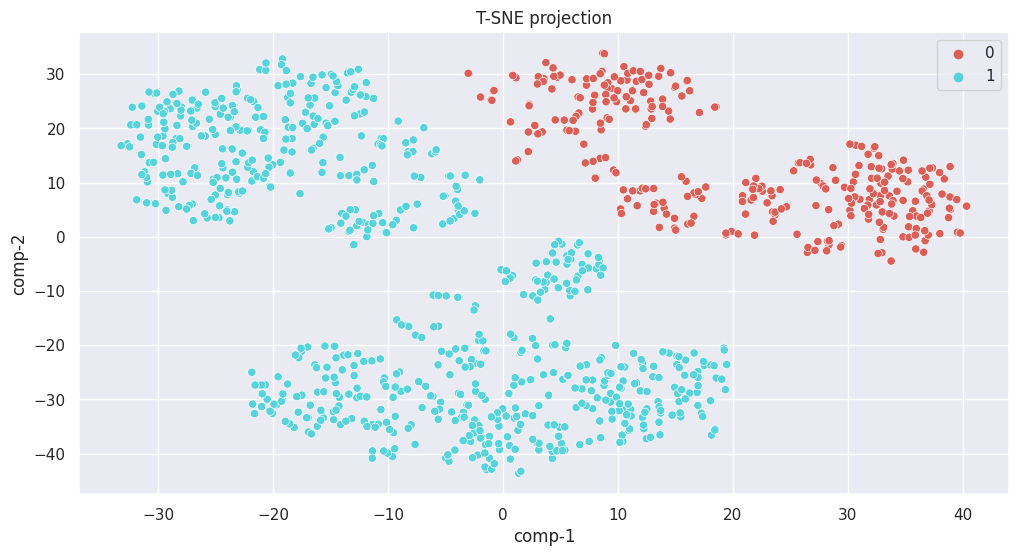

In [80]:
# Візуалізація
df_tsne = pd.DataFrame()
df_tsne["y"] = df["credit_risk"]
df_tsne["comp-1"] = x_2d[:, 0]
df_tsne["comp-2"] = x_2d[:, 1]

sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df_tsne.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df_tsne
).set(title="T-SNE projection")

Можемо побачити що t-SNE дійсно поділив дані на 2 кластери, при чому значення потенційного таргета `credit_risk` присутні в обох кластерах. Візуально ж можно сказати, що дані можна поділити на 3 кластери.

Тепер подивимось за допомогою PCA як ми можемо розмірність датасету, щоб не втратити більше ніж 70% даних.


# PCA

In [81]:
# Тренуємо PCA
from sklearn.decomposition import PCA

pca = PCA().fit(X)

In [82]:
len(pca.explained_variance_ratio_)

19

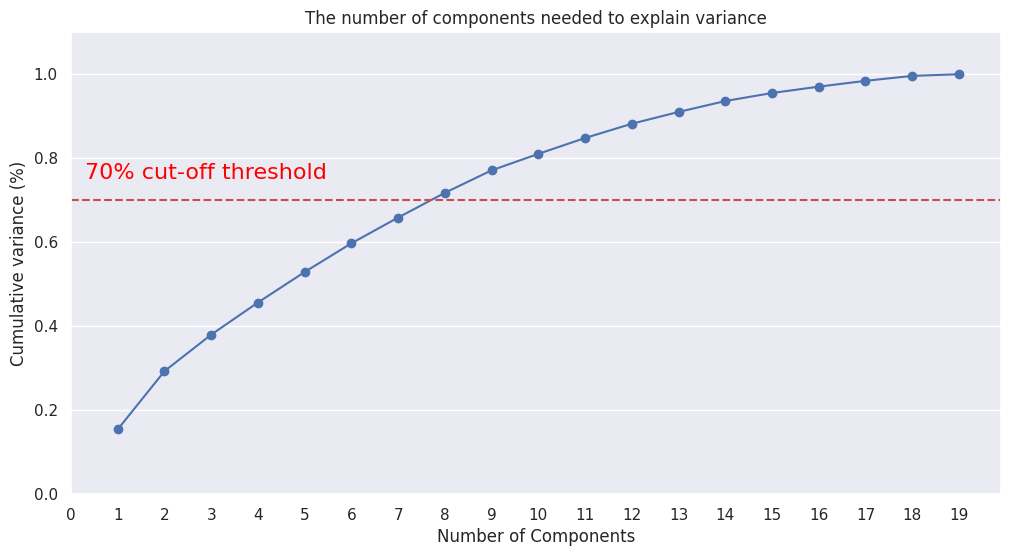

In [83]:
# Візуалізуємо результат
plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()
xi = np.arange(1, 20, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker="o", linestyle="-", color="b")

plt.xlabel("Number of Components")
plt.xticks(np.arange(0, 20, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.70, color="r", linestyle="--")
plt.text(0.3, 0.75, '70% cut-off threshold', color="red", fontsize=16)

ax.grid(axis="x")
plt.show()

По цьому графіку можемо побачити, що нам потрібно лише 8 головних компонентів (фічей), щоб описати трохи більше, ніж 70% даних. Тобто поточна кількість фічей може бути снижена.

In [84]:
# Подивимось долі дисперсії
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Компонента {i + 1}: {ratio:.4f}")

Компонента 1: 0.1545
Компонента 2: 0.1386
Компонента 3: 0.0870
Компонента 4: 0.0765
Компонента 5: 0.0726
Компонента 6: 0.0683
Компонента 7: 0.0613
Компонента 8: 0.0589
Компонента 9: 0.0535
Компонента 10: 0.0392
Компонента 11: 0.0378
Компонента 12: 0.0339
Компонента 13: 0.0281
Компонента 14: 0.0260
Компонента 15: 0.0192
Компонента 16: 0.0151
Компонента 17: 0.0138
Компонента 18: 0.0118
Компонента 19: 0.0039


In [85]:
# Зменшимо дані до 8 фічей за допомогою PCA
pca = PCA(n_components=8)
reduced_X = pca.fit_transform(X)
print(X.shape)
print(reduced_X.shape)

(1000, 19)
(1000, 8)


[Text(0.5, 1.0, 'T-SNE projection')]

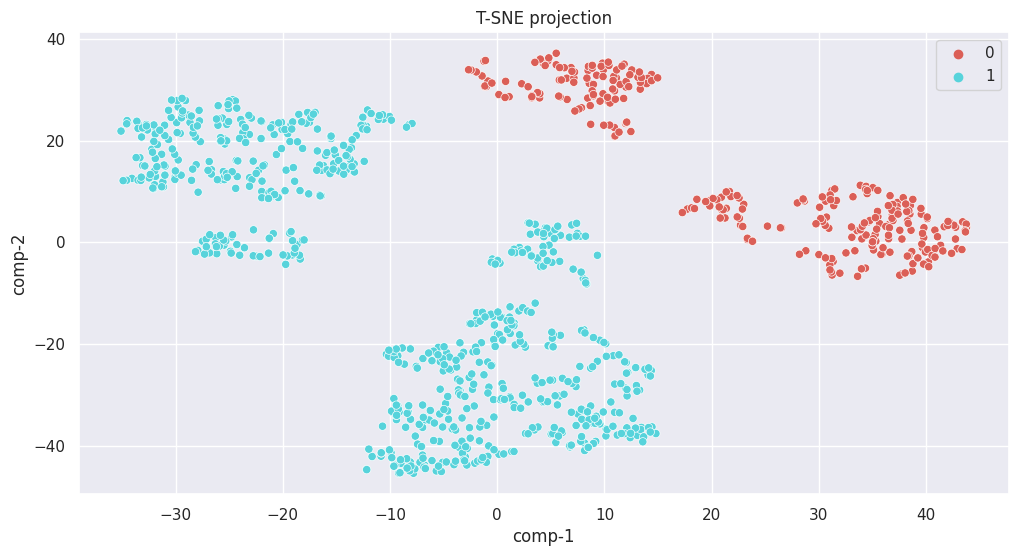

In [87]:
# t-SNE
x_reduced_2d = TSNE(n_components=2, random_state=42).fit_transform(reduced_X)

# Візуалізація
df_tsne = pd.DataFrame()
df_tsne["y"] = df["credit_risk"]
df_tsne["comp-1"] = x_reduced_2d[:, 0]
df_tsne["comp-2"] = x_reduced_2d[:, 1]

sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df_tsne.y.tolist(),
    palette=sns.color_palette("hls", 2),
    data=df_tsne
).set(title="T-SNE projection")

Після зменшення розмірності візуально виглядає так, що дані тепер можно розбити на 4 кластери.

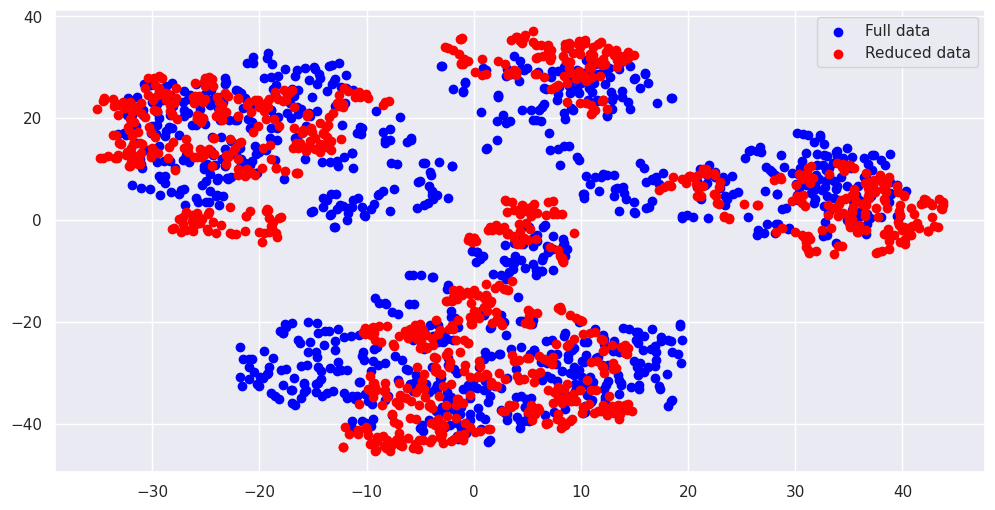

In [88]:
# Побудуємо графік, на якому будуть накладені точки після обох t-SNE перетворень
plt.scatter(x_2d[:, 0], x_2d[:, 1], color="blue", label="Full data")
plt.scatter(x_reduced_2d[:, 0], x_reduced_2d[:, 1], color="red", label="Reduced data")
plt.legend()
plt.show()

In [89]:
# Та подивимось, чи є у нас точки, координати яких перетинаються
a = set((tuple(i) for i in x_2d))
b = set((tuple(i) for i in x_reduced_2d))
print(a.intersection(b))

set()


Явних точок перетину серед даних після першої t-SNE транформації і другої немає, але візуально по графіку можно побачити що деякі точки дуже близько до цього.

Тепер перевіримо, як зменшення розмірності вплине на результат кластерізації.

# Кластерізація на датасеті з меншою розмерністю

In [90]:
# KMeans
for k in range(2, max_clusters_num + 1):
  kmeans = KMeans(
      n_clusters=k,
      random_state=42,
      n_init="auto",
  ).fit(reduced_X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, kmeans.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, kmeans.labels_)}")
  print(f"Silhouette score: {silhouette_score(reduced_X, kmeans.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 2.0161844781739227
Calinski and Harabasz score: 224.21038008287016
Silhouette score: 0.19289725038249822 

Number of clusters: 3
Davies-Bouldin score: 1.7678836672990108
Calinski and Harabasz score: 216.8020255865529
Silhouette score: 0.20137905016995256 

Number of clusters: 4
Davies-Bouldin score: 1.8131967702681346
Calinski and Harabasz score: 168.4252306407011
Silhouette score: 0.19536464914193152 

Number of clusters: 5
Davies-Bouldin score: 1.7635846883657336
Calinski and Harabasz score: 158.4467946244667
Silhouette score: 0.20862307547484352 

Number of clusters: 6
Davies-Bouldin score: 1.83722984679233
Calinski and Harabasz score: 149.2186527099347
Silhouette score: 0.18187556562542745 



Бачимо, що KMeans вже не дуже впевнений щодо 2 кластерів. Якщо порівнювати метріки, то навіть складно виділити якусь кількість кластерів, яка має певну перевагу. Наче 3, але давайте подивимось ще на Clustergram та результати інших моделей.

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.028249502182006836 seconds.
K=3 fitted in 0.021549463272094727 seconds.
K=4 fitted in 0.03223443031311035 seconds.
K=5 fitted in 0.030605316162109375 seconds.
K=6 fitted in 0.05573678016662598 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

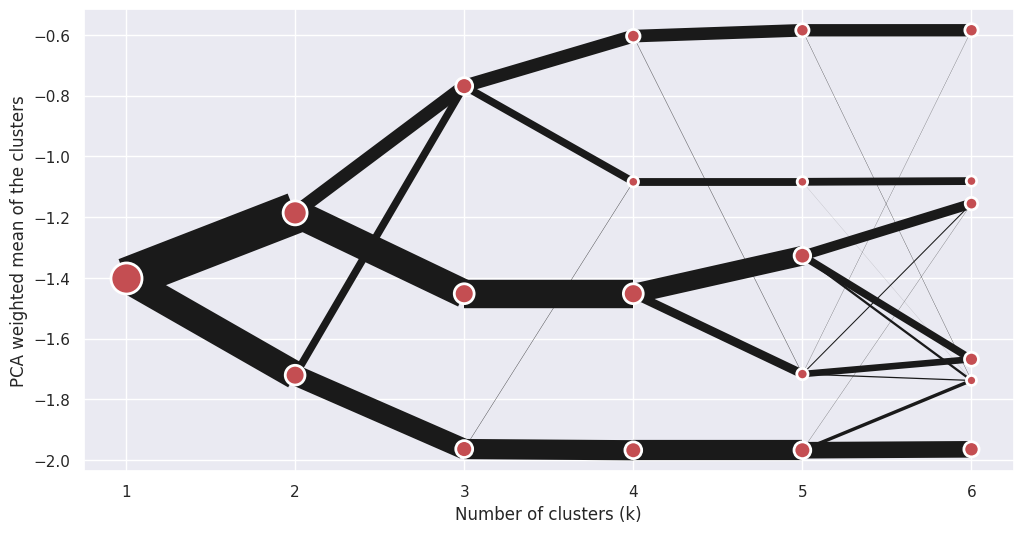

In [91]:
cgram.fit(reduced_X)
cgram.plot()

Clustergram наче не показує нічого нового. Подивимось на інші моделі.

In [92]:
# AffinityPropagation
aff_prop = AffinityPropagation(random_state=42).fit(reduced_X)
print(f"Clusters labels: {np.unique(aff_prop.labels_)}")
print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, aff_prop.labels_)}")
print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, aff_prop.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_X, aff_prop.labels_)}", "\n")

Clusters labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
Davies-Bouldin score: 1.2783891313229132
Calinski and Harabasz score: 67.39768674225695
Silhouette score: 0.20937770244600906 



Кількість пропонуємих кластерів у AffinityPropagation знизилась з 75 до 61.

In [93]:
# MeanShift
ms = MeanShift(bandwidth=2).fit(reduced_X)
labels = np.unique(ms.labels_)

print(f"Clusters labels: {labels}")

if len(labels) > 1:
  print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, ms.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, ms.labels_)}")
  print(f"Silhouette score: {silhouette_score(reduced_X, ms.labels_)}", "\n")

Clusters labels: [0]


MeanShift так і не знайшов більше одного кластера.

In [94]:
# SpectralClustering
for k in range(2, max_clusters_num + 1):
  kmeans = SpectralClustering(
      n_clusters=k,
      random_state=42,
  ).fit(reduced_X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, kmeans.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, kmeans.labels_)}")
  print(f"Silhouette score: {silhouette_score(reduced_X, kmeans.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 2.256580905081362
Calinski and Harabasz score: 179.90029696505226
Silhouette score: 0.1559831098148493 

Number of clusters: 3
Davies-Bouldin score: 1.7829024775364217
Calinski and Harabasz score: 212.9954522792222
Silhouette score: 0.19865453908356584 

Number of clusters: 4
Davies-Bouldin score: 1.7980899572372957
Calinski and Harabasz score: 169.02521447135095
Silhouette score: 0.17227713133861128 

Number of clusters: 5
Davies-Bouldin score: 1.7160086164597754
Calinski and Harabasz score: 149.40308030261318
Silhouette score: 0.1670262749492063 

Number of clusters: 6
Davies-Bouldin score: 1.6916908970764861
Calinski and Harabasz score: 145.62408312028637
Silhouette score: 0.18000407943692465 



SpectralClustering вже більше вказує на 3 кластери.

In [95]:
# AgglomerativeClustering
for k in range(2, max_clusters_num + 1):
  agg = AgglomerativeClustering(n_clusters=k).fit(reduced_X)
  print(f"Number of clusters: {k}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, agg.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, agg.labels_)}")
  print(f"Silhouette score: {silhouette_score(reduced_X, agg.labels_)}", "\n")

Number of clusters: 2
Davies-Bouldin score: 1.9501066615381866
Calinski and Harabasz score: 205.94140386534048
Silhouette score: 0.19415251542046888 

Number of clusters: 3
Davies-Bouldin score: 1.9725777627005234
Calinski and Harabasz score: 175.85861749250336
Silhouette score: 0.1595678910385667 

Number of clusters: 4
Davies-Bouldin score: 1.7995898042643677
Calinski and Harabasz score: 161.57358477394058
Silhouette score: 0.17888883054303467 

Number of clusters: 5
Davies-Bouldin score: 1.7628803682112575
Calinski and Harabasz score: 154.22514850640943
Silhouette score: 0.19982336232443237 

Number of clusters: 6
Davies-Bouldin score: 1.7257183376941434
Calinski and Harabasz score: 143.73487739823
Silhouette score: 0.20200148390723802 



AgglomerativeClustering теж наче більше схиляється до 3-х кластерів.

In [96]:
# DBSCAN
for i in range(1, max_clusters_num):
  dbs = DBSCAN(eps=i, min_samples=2).fit(reduced_X)
  labels = np.unique(dbs.labels_)

  print(f"Epsilon value: {i}")
  print(f"Clusters labels: {labels}")

  if len(labels) > 1:
    print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, dbs.labels_)}")
    print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, dbs.labels_)}")
    print(f"Silhouette score: {silhouette_score(reduced_X, dbs.labels_)}", "\n")

Epsilon value: 1
Clusters labels: [-1  0]
Davies-Bouldin score: 1.7558513177962438
Calinski and Harabasz score: 2.4066300322226213
Silhouette score: 0.20365355957789377 

Epsilon value: 2
Clusters labels: [0]
Epsilon value: 3
Clusters labels: [0]
Epsilon value: 4
Clusters labels: [0]
Epsilon value: 5
Clusters labels: [0]


DBSCAN з epsilon=1 знайшов лише один кластер, інші дані помітив як шум.

In [97]:
# Спробуємо також автоматичний Birch
brc = Birch(n_clusters=None).fit(reduced_X)
print(f"Clusters labels: {np.unique(brc.labels_)}")
print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, brc.labels_)}")
print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, brc.labels_)}")
print(f"Silhouette score: {silhouette_score(reduced_X, brc.labels_)}", "\n")

Clusters labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170]
Davies-Bouldin score: 0.9887703815862611
Calinski and Harabasz score: 42.175456127370325
Silhouette score: 0.17975077287539268 



Вже не 613, але 170 ще також багато для нашего датасету.

In [98]:
# Та Birch с зазначенною кількостю кластерів
for k in range(2, max_clusters_num + 1):
  brc = Birch(n_clusters=k).fit(reduced_X)
  print(f"Clusters labels: {np.unique(brc.labels_)}")
  print(f"Davies-Bouldin score: {davies_bouldin_score(reduced_X, brc.labels_)}")
  print(f"Calinski and Harabasz score: {calinski_harabasz_score(reduced_X, brc.labels_)}")
  print(f"Silhouette score: {silhouette_score(reduced_X, brc.labels_)}", "\n")

Clusters labels: [0 1]
Davies-Bouldin score: 2.018491756086501
Calinski and Harabasz score: 223.34569334248104
Silhouette score: 0.1924086152341033 

Clusters labels: [0 1 2]
Davies-Bouldin score: 1.9734278054279015
Calinski and Harabasz score: 158.0469936768456
Silhouette score: 0.1888666514405926 

Clusters labels: [0 1 2 3]
Davies-Bouldin score: 1.852736227040102
Calinski and Harabasz score: 146.84584121694897
Silhouette score: 0.18719878740196086 

Clusters labels: [0 1 2 3 4]
Davies-Bouldin score: 1.7107845504976082
Calinski and Harabasz score: 156.7098482833878
Silhouette score: 0.20113458117568705 

Clusters labels: [0 1 2 3 4 5]
Davies-Bouldin score: 1.7113278805829804
Calinski and Harabasz score: 140.75877047959148
Silhouette score: 0.20387442583396337 



Тут Birch наче більш схилений до 4-х кластерів.

# Висновок

В цій роботі ми ознайомились з моделями кластерізації та методами зниження розмірності та візуалізації, такими як PCA та t-SNE. Можна зазначити, що метрики моделей кластерізації не можна використовувати для якісного оцінювання, але можна за допомогою них роботи оцінювальне порівняння.

Що до зниження розмірності, то можна впевенно сказати, що цей підхід допомагає визначити біль якісні компоненти для кластерізації та підвищити її якість.

Так, наприклад, до зниження розмірності моделі кластерізації більш вказували на 2 кластери у нашому датасеті, а післі зменшення розмірності - вже на 3-4, що є білш правильним, якщо вважати візуалізацію.

Звичайно, для більш точного розділення потрібні додаткові експерименти, наприклад з параметрами моделей кластеризації. Також ще можна провести додатковий feature engineering та подивитися як це вплине на фінальний результат.